In [32]:
suppressPackageStartupMessages(suppressWarnings({
    library(tidyr)
    library(ggplot2)
    library(dplyr)
    library(igraph)
    library(gtools)
    library(gridExtra)
    library(network)
    library(sna)
    library(ggnetwork)
    library(igraph)
}))

In [33]:
#data initialisation functions

# empty matrix dims p x p
# set to ident matrix
# rbinom <- number of observations, size of trials, probability of success
# scale() forces column centering by subtracting mean of each column from their data points
# d <- split each column into the list and add randomly distributed numbers to each element
# do.call(cbind, d) concatenates the list elements to reform the previous matrix representation

init_data <- function(n, p){
    r <- matrix(0, p, p)
    diag(r) <- 1
    g <- scale(matrix(rbinom(n*p, 2, 0.5), n))
    d <- list()
    for(i in 1:p){
        d[[i]] <- g[,i] + rnorm(n)
    }
    d <- do.call(cbind, d)
    return(list(r=r, d=d, g=g))
}

# r is a p x p ident matrix, this sets location j, i to the effect
# d is the scaled data representation, this adds the value of d[,i] * the effect to d[,j]
make_edge <- function(i, j, effect, data)
{
    data$r[j, i] <- effect
    data$d[,j] <- data$d[,j] + data$d[,i] * effect
    return(data)
}


In [34]:
# is.finite() & is.finite() pairwise AND comparison of integer finiteness, Inf, Inf, NaN, Na all result in False
# sum tallies the number of True occurences
# y[index] strips y to only finite values
# rsq = correlation^2
# this is the square of the correlation coefficient
# tval = pearson product-moment correlation coefficient fval is the square of tval
# this is identical to the built-in R cor() pearson method
# pf is a cumulative distribution function(values, numerator dgf, denom dgf, tail or not)

fastAssoc <- function(y, x){
    index <- is.finite(y) & is.finite(x)
    n <- sum(index)
    y <- y[index]
    x <- x[index]
    
    vx <- var(x)
    bhat <- cov(y, x) / vx
    ahat <- mean(y) - bhat * mean(x)
    

    rsq <- (cov(y, x))^2 / (vx * var(y))
    fval <- rsq * (n-2) / (1-rsq)
    tval <- sqrt(fval)
    se <- abs(bhat / tval)
    
    p <- pf(fval, 1, n-2, lowe=F)
    return(
        list(ahat=ahat, bhat=bhat, se=se, fval=fval, pval=p)
    )
}

# Simple linear regression applied to data based on least square estimates bhat and ahat
# bhat = conv(y, x)/var(x)
# ahat = Ex(y) - bhat * Ex(x)
# fitted values Y : Yi = ahat + bhat * xi

getFittedVals <- function(y, x){
    n <- length(x)
    bhat <- cov(y, x) / var(x)
    ahat <- mean(y) - bhat * mean(x)
    fitted <- ahat + x * bhat
    return(fitted)
}

#tsls gets the fitted values for some data, and then applies fastAssoc to the resulting data with the original data

tsls <- function(y, x, g){
    xhat <- getFittedVals(x, g)
    res <- fastAssoc(y, xhat)
    return(res)
}

# ncol(data) number of columns in data
# make matrix of size p x p, all ones
# same but all zeroes
# for all none diagonal matrices{
# b non-diagonals set to bhat value, cov(y, x)/var(x), diags = cov(x, x)/var(x) = 1
# se non-diagonals set to se value, abs(bhat/tval)
# }

graph_mr <- function(data){
    p <- ncol(data$d)
    b <- matrix(1, p, p)
    se <- matrix(0, p, p)
    for(i in 1:p){
        for(j in 1:p){
            if(i != j){
                a <- tsls(data$d[, i], data$d[, j], data$d[, j])
                b[i, j] <- a$bhat
                se[i, j] <- a$se
            }
        }
    }
    return(list(b=b, se=se))
}

# stopifnot used to prevent indexing outside the matrix, or performing checks on a single node matrix
# a is a vector of form (first, list of nodes w/out first and last, last)
# permutations is of the form (size of input, size of target, data)
# first permutations for single step paths x -> y -> z are calced, then for increasing path size up to graph size
# find only perms with start = index 1 and last = final index
# only accept unique paths 2 1 4 3 is considered the same as 2 4 1 3
# Returned list are all paths from first to last ordered by increasing size

get_paths <- function(first, last, size)
{
    stopifnot(first <= size)
    stopifnot(last <= size)
    stopifnot(size > 2)
    a <- c(first, c(1:size)[-c(first, last)], last)
    combs <- 3:size
    l <- list()
    for(i in combs)
    {
        b <- permutations(size, i, a)
        b <- b[b[,1] == first & b[,i] == last, , drop=FALSE]
        b1 <- b[,-c(1, ncol(b)), drop=FALSE]
        index <- apply(b1, 1, function(x) all(diff(x) >= 1))
        l[[i-2]] <- b[index, , drop=FALSE]
    }
    return(l)
}

# for each path size, for each path, get the length of the path minus 1, create a zero vector of that length
# set each element of that vector to the mat weight of that edge on the current path
# get the effect product for the path and add to the total product

get_prods <- function(paths, mat)
{
    s <- 0
    for(i in 1:length(paths))
    {
        p <- paths[[i]]
        for(j in 1:nrow(p))
        {
            r <- p[j, ]
            l <- length(r) - 1
            out <- rep(0, l)
            for(k in 1:l)
            {
                out[k] <- mat[r[k], r[k+1]]
            }
            s <- s + prod(out)
        }
    }
    return(s)
}


In [47]:
# Methods:

# a = negative of the inversion of res$b, with diag set to 1, as trait self-relations are trivially related
inversion_method <- function(res){
    a <- -solve(res$b)
    diag(a) <- 1
    return(a)
}

# n = number of rows
# mmat is a zero matrix the same size as res$b
# diag of mmat set to 1 as discussed above
# for none diags, minus the prods of possible i, j paths from the current effect i, j
mediation_method <- function(res){
    mat <- res$b
    n <- nrow(mat)
    mmat <- matrix(0, nrow(mat), ncol(mat))
    for(i in 1:n){
        for(j in 1:n){
            if(i == j){
                mmat[i,j] <- 1
            } else {
                p <- get_paths(i, j, n)
                mmat[i,j] <- mat[i,j] - get_prods(p, mat)
            }
        }
    }
    return(mmat)
}

# set the diag of mat to zero, then get the inverse of (ident matrix (size nrow(mat)) + original matrix)
# then matrix multiply with mat
deconvolution_method <- function(res){
    mat <- res$b
    diag(mat) <- 0
    out <- mat %*% solve(diag(nrow(mat)) + mat)
    return(out)
}

# make correlation matrix
# obfuscating function call for my own readability
make_cor_mat <- function(d){
    out$b <- cor(d)
    return(out)
}

In [41]:
# visualisation functions

plot_from_matrix <- function(mat, title="")
{
    diag(mat) <- 0
    net <- graph.adjacency(round(t(mat), 1), weighted=TRUE, mode="directed")
    layout=layout.circle(net)
    plot(net, edge.label = E(net)$weight, main=title, layout=layout)
}

plot_from_matrix_clean <- function(mat, title="")
{
	diag(mat) <- 0
	n <- network(round(t(mat), 1))
	p <- ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
	geom_edges(arrow = arrow(length = unit(6, "pt"), type = "closed")) +
	geom_nodes() +
	theme_blank() +
	labs(title=title)
	return(p)
}

Warning message in out$b <- cor(d):
"Coercing LHS to a list"

$b
          [,1]          [,2]         [,3]         [,4]
[1,]  1.000000 -0.0002991861  0.001446515 -0.000550320
[2,]  1.997868  1.0000000000 -0.001250140  0.001253075
[3,] 12.992960  2.9948240764  1.000000000  0.000682079
[4,] -9.990240 -3.9993557893  0.001758456  1.000000000

$se
            [,1]        [,2]        [,3]        [,4]
[1,] 0.000000000 0.002006038 0.001990705 0.002010487
[2,] 0.003467191 0.000000000 0.004450964 0.004495192
[3,] 0.019455429 0.026500136 0.000000000 0.026895969
[4,] 0.016386188 0.020946903 0.021531235 0.000000000

[[1]]
[1] 0

[[2]]
[1] 0

$b
           [,1]       [,2]       [,3]       [,4]
[1,]  1.0000000  0.8945222  0.9717375 -0.9246145
[2,]  0.8945222  1.0000000  0.9693483 -0.9922735
[3,]  0.9717375  0.9693483  1.0000000 -0.9812257
[4,] -0.9246145 -0.9922735 -0.9812257  1.0000000



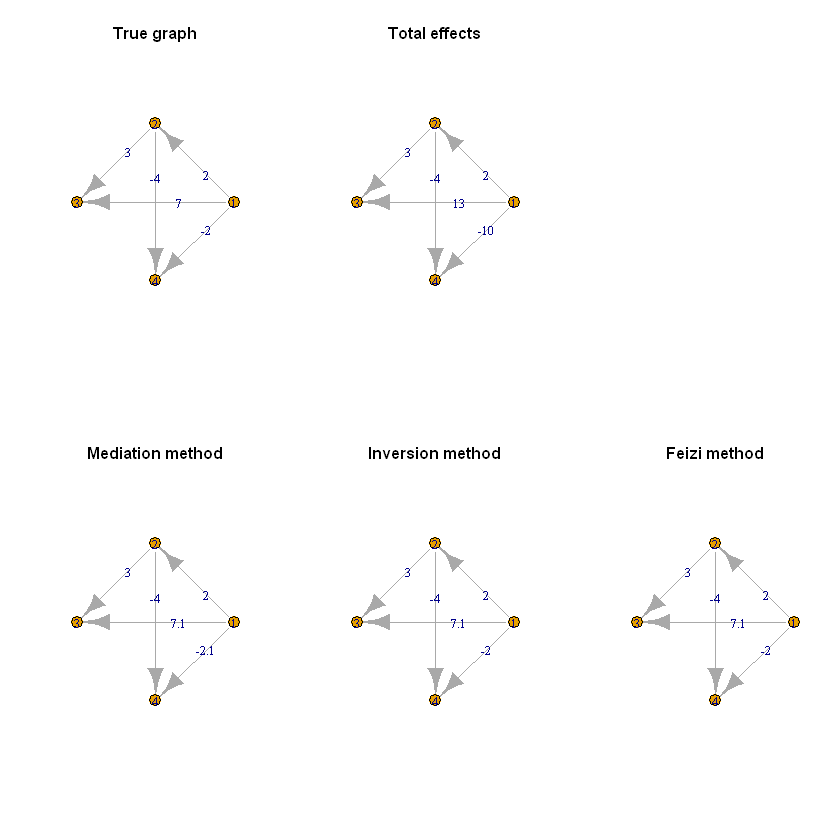

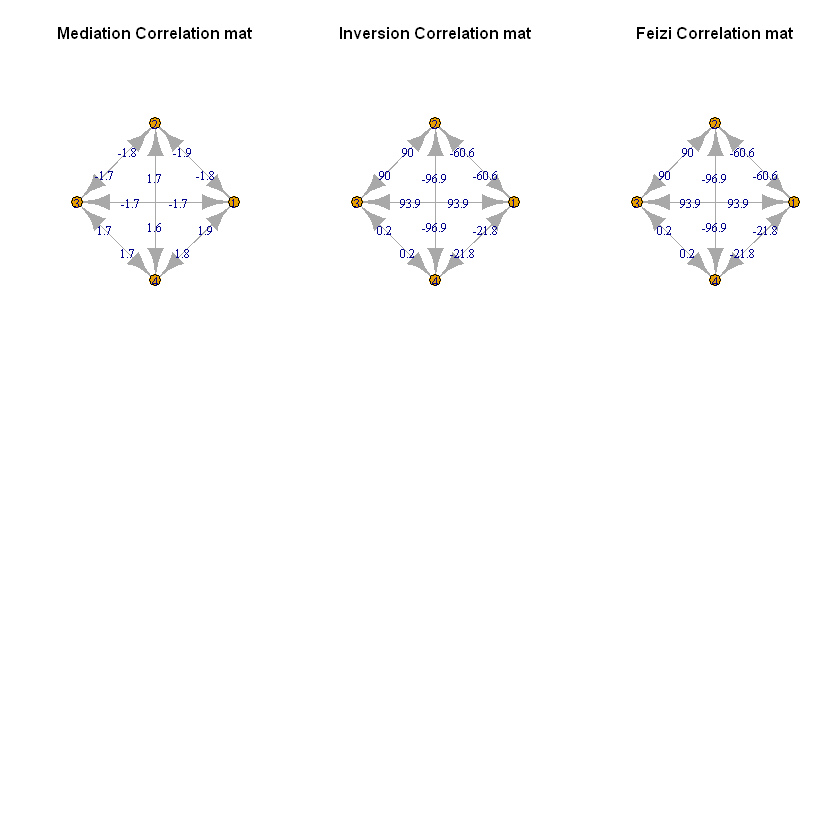

In [49]:
dat <- init_data(500000, 4)
dat <- make_edge(1,2,2, dat)
dat <- make_edge(2,3,3, dat)
dat <- make_edge(1,3,7, dat)
dat <- make_edge(1,4,-2, dat)
dat <- make_edge(2,4,-4, dat)

res <- graph_mr(dat)
corr <- make_cor_mat(dat$d)
print(res)
print(corr)
res1 <- mediation_method(res)
res2 <- inversion_method(res)
res3 <- deconvolution_method(res)
res4 <- mediation_method(corr)
res5 <- inversion_method(corr)
res6 <- deconvolution_method(corr)
diag(dat$r) <- NA
resall <- rbind(
    data.frame(estimate=c(res1), truth=c(dat$r), method="Mediation"),
    data.frame(estimate=c(res2), truth=c(dat$r), method="Inversion"),
    data.frame(estimate=c(res3), truth=c(dat$r), method="Feizi"),
    data.frame(estimate=c(res$b), truth=c(dat$r), method="Total effects"),
    data.frame(estimate=c(res4), truth=c(dat$r), method="Mediation Correlation mat"),
    data.frame(estimate=c(res5), truth=c(dat$r), method="Inversion Correlation mat"),
    data.frame(estimate=c(res6), truth=c(dat$r), method="Feizi Correlation mat")
)

par(mfrow=c(2,3))
plot_from_matrix(dat$r, "True graph")
plot_from_matrix(res$b, "Total effects")
plot(1, type="n", axes=F, xlab="", ylab="")
plot_from_matrix(res1, "Mediation method")
plot_from_matrix(res2, "Inversion method")
plot_from_matrix(res3, "Feizi method")
plot_from_matrix(res4, "Mediation Correlation mat")
plot_from_matrix(res5, "Inversion Correlation mat")
plot_from_matrix(res6, "Feizi Correlation mat")